# Face Helpers
In this notebook we'll implement some helper functions.
The datasets we use present examples (x,y) in this form:
* x: frame extracted from a video
* y: label associated to the frame. This label contains the active Action Unit of the frame
<br>

Our aim is to apply a pipeline of operations on each single frame:
1. Take over the face of the subject present in the frame
2. Take over the landmarks of the face
3. Face Alignment and Masking
4. HOG extraction

In this notebook we implement helper functions needed to apply these four operations.

***

### 1. Take over the face of the subject
Printing of an image.

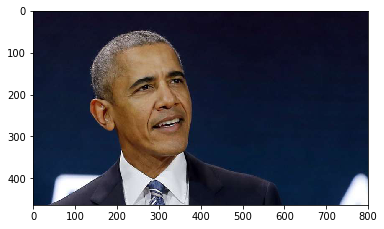

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(img):
    imgplot = plt.imshow(img)
    plt.show()

def show_image_from_path(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

show_image_from_path('images/obama2.jpeg')

<br>

Take over the face of the subject, using the lib [Face Recognition](https://github.com/ageitgey/face_recognition).

I found a number of faces equals to 1.
A face is here:   Top: 93, Left: 191, Bottom: 316, Right: 414


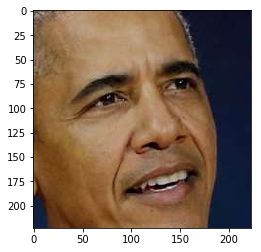

In [5]:
import dlib
import face_recognition
from PIL import Image


def get_face_locations(path, verbose=True):
    # Load the image in a numpy array
    if type(path) == str:
        img = face_recognition.load_image_file(path)
    else:  # Case in which "path" is an image
        img = path.convert('RGB')
        img = np.array(img)

    # This will find all the faces in the image, using the default model (based on HOG)
    face_locations = face_recognition.face_locations(img)
    if verbose:
        print("I found a number of faces equals to {}.".format(len(face_locations)))

    for face_location in face_locations:
        # Stampa la posizione di ogni faccia che ha trovato
        top, right, bottom, left = face_location
        if verbose:
            print("A face is here:   Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

        face_image = img[top:bottom, left:right]
        out_image = Image.fromarray(face_image)
    return out_image   # It returns the last face founded
        
        
face_image = get_face_locations("images/obama2.jpeg", verbose=True)
show_image(face_image)

***

### 2. Landmark extraction
Landmark extraction, using again [Face Recognition](https://github.com/ageitgey/face_recognition).

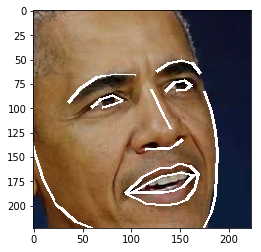

In [7]:
from PIL import Image, ImageDraw
import face_recognition
import numpy

def get_landmarks(img):
    # Load the image which contains only the face in a numpy array
    img = numpy.array(img)

    # Get alla the face landmarks
    landmarks = face_recognition.face_landmarks(img)

    # Creation of a new imagine on which we'll draw the landmarks
    pil_image_drawn = Image.fromarray(img)
    d = ImageDraw.Draw(pil_image_drawn)

    for face_landmarks in landmarks:
        # Print the position of each landmark
        #for facial_feature in face_landmarks.keys():
        #    print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

        # Draw the landmarks
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], fill='white', width=3)

    # Returns the list of landmarks 
    return (landmarks, pil_image_drawn)


(face_landmarks_list, image_drawn) = get_landmarks(face_image)
show_image(image_drawn)

***

### 3. Face Alignment and Masking
Code adapted starting from [this tutorial](https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/).

In [8]:
import FaceAligner
import cv2
import numpy as np

# Create an object which allows us to align the face in the image
fa = FaceAligner.FaceAligner()


def translate_eyebrow_landmarks(landmarks):
    new_left_eyebrow = [(tup[0], tup[1]-15) for tup in landmarks[0]['left_eyebrow']]
    new_right_eyebrow = [(tup[0], tup[1]-15) for tup in landmarks[0]['right_eyebrow']]
    landmarks[0]['left_eyebrow'] = new_left_eyebrow
    landmarks[0]['right_eyebrow'] = new_right_eyebrow


def get_aligned_face(img, landmarks):
    # From the landmarks list (which contains a dict with the features) we obtain a flat array
    lista_landmarks = list()
    translate_eyebrow_landmarks(landmarks)  # in this way we'll keep a piece of the forehead
    for el in landmarks[0].values():
        lista_landmarks.append(el)
    lista_landmarks = [item for sublist in lista_landmarks for item in sublist]

    # Load the image and the landmarks list (shape) in a numpy array 
    img = np.asarray(img)
    shape = np.asarray(lista_landmarks)

    # Creation of a mask
    remapped_shape = np.zeros_like(shape) 
    feature_mask = np.zeros((img.shape[0], img.shape[1]))   

    # From the image we extract only the portion of the face which is inside the landmarks
    remapped_shape = cv2.convexHull(shape)
    cv2.fillConvexPoly(feature_mask, remapped_shape[0:27], 1)
    feature_mask = feature_mask.astype(np.bool)

    # Creation of the output image...
    out_face = np.zeros_like(img)
    out_face[feature_mask] = np.asarray(img)[feature_mask]
    
    # ...and we align it
    out_face = fa.align(out_face, lista_landmarks, desiredFaceWidth=img.shape[0])
    return out_face



def crop_image(img, tol=0):
    # Mask for pixels whose value is greater than a tolerance threshold
    mask = img > tol

    # The position of these pixels
    coords = np.argwhere(mask)

    # Bounding box which contains these pixels
    minCoords = coords.min(axis=0)
    x0 = minCoords[0]
    y0 = minCoords[1]
    maxCoords = coords.max(axis=0) + 1  # slices are exclusive at the top
    x1 = maxCoords[0]   
    y1 = maxCoords[1]

    # We get the content of the Bounding Box
    cropped = img[x0:x1, y0:y1]
    return cropped

def align_and_crop(img, landmarks, tol=0):
    img = get_aligned_face(img, landmarks)
    img = crop_image(img)
    img = np.asarray(Image.fromarray(img).resize((112,112)))
    return img

112 x 112


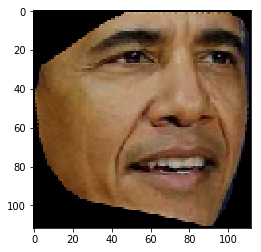

In [9]:
#out_face = get_aligned_face(face_image, face_landmarks_list)
#out_face = crop_image(out_face)
#out_face = np.asarray(Image.fromarray(out_face).resize((112,112)))

out_face = align_and_crop(face_image, face_landmarks_list)

print("{} x {}".format(out_face.shape[0], out_face.shape[1]))
show_image(out_face)

(face_landmarks_list, image_drawn) = get_landmarks(out_face)  # ricalcolo i landmark su questo nuova immagine 112x112
#show_image(image_drawn)

***

### 4. HOG extraction
Using the lib [scikit-image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

(6084,)


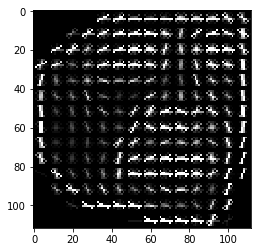

In [10]:
from skimage.feature import hog
from skimage import data, exposure

def show_gray_image(img):
    imgplot = plt.imshow(img, cmap=plt.cm.gray)
    plt.show()

def get_hog_features(img, flat_vector=True, return_image=False):
    if return_image:
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=return_image, 
                    multichannel=True, block_norm='L2-Hys', feature_vector=flat_vector)
        # Scaling of the intensities for a better visualization
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 15))
        return fd, hog_image_rescaled
    else:
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=return_image, 
                    multichannel=True, block_norm='L2-Hys', feature_vector=flat_vector)
        return fd
    
features, hog_image = get_hog_features(out_face, flat_vector=True, return_image=True)
print(features.shape)
show_gray_image(hog_image)

***